In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [3]:

# Step 1: Configuration
original_dir = "./rice_leaf_dataset"  # Path to your dataset
output_dir = "./dataset"             # Where train_val and test are located
test_split = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 50
VALIDATION_SPLIT = 0.2
random.seed(42)

In [5]:
# Step 3: Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input  # EfficientNet-specific preprocessing
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train_val'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train_val'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())
print(f"Classes: {NUM_CLASSES}, Labels: {class_labels}")
print(f"Train images: {train_generator.samples}, Validation images: {val_generator.samples}, Test images: {test_generator.samples}")

Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Classes: 4, Labels: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']
Train images: 3799, Validation images: 948, Test images: 1185


In [11]:
# Step 4: Build EfficientNetB0 model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=x)

efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
efficientnet_base.trainable = True  # unFreeze base model
efficientnet_model = build_model(efficientnet_base)
efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [12]:
# Step 5: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("./efficientnetb0_rice_leaf_best.h5", monitor='val_loss', save_best_only=True)

In [13]:
# Step 6: Train model
efficientnet_history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6336 - loss: 0.9289

76/76 ━━━━━━━━━━━━━━━━━━━━ 555s 7s/step - accuracy: 0.6357 - loss: 0.9246 - val_accuracy: 0.2426 - val_loss: 1.4353 - learning_rate: 1.0000e-04
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9697 - loss: 0.1266

76/76 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - accuracy: 0.9699 - loss: 0.1261 - val_accuracy: 0.1930 - val_loss: 1.3936 - learning_rate: 1.0000e-04
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 414s 5s/step - accuracy: 0.9926 - loss: 0.0322 - val_accuracy: 0.2827 - val_loss: 1.4386 - learning_rate: 1.0000e-04
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 413s 5s/step - accuracy: 0.9957 - loss: 0.0204 - val_accuracy: 0.1656 - val_loss: 1.5095 - learning_rate: 1.0000e-04
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - accuracy: 0.9966 - loss: 0.0133 - val_accuracy: 0.2310 - val_loss: 1.4431 - learning_rate: 1.0000e-04
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 503s 7s/step - accuracy: 0.9973 - loss: 0.0092 - val_accuracy: 0.3038 - val_loss: 2.3159 - learning_rate: 1.0000e-04
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 427s 6s/step - accuracy: 0.9995 - loss: 0.0049 - val_accuracy: 0.3544 - val_loss: 1.6926 - learning_rate: 1.0000e-04


In [17]:
# Step 7: Evaluate model
val_loss, val_acc = efficientnet_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
test_loss, test_acc = efficientnet_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2432 - loss: 1.4030
Validation Loss: 1.3937, Accuracy: 0.1994
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 903ms/step - accuracy: 0.2719 - loss: 1.4067
Test Loss: 1.3946, Accuracy: 0.2211


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 964ms/step
Test Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.13      0.16      0.14       316
          Blast       0.27      0.73      0.39       288
      Brownspot       0.00      0.00      0.00       320
         Tungro       0.18      0.01      0.01       261

       accuracy                           0.22      1185
      macro avg       0.14      0.22      0.14      1185
   weighted avg       0.14      0.22      0.14      1185



c:\Users\longp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\longp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\longp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

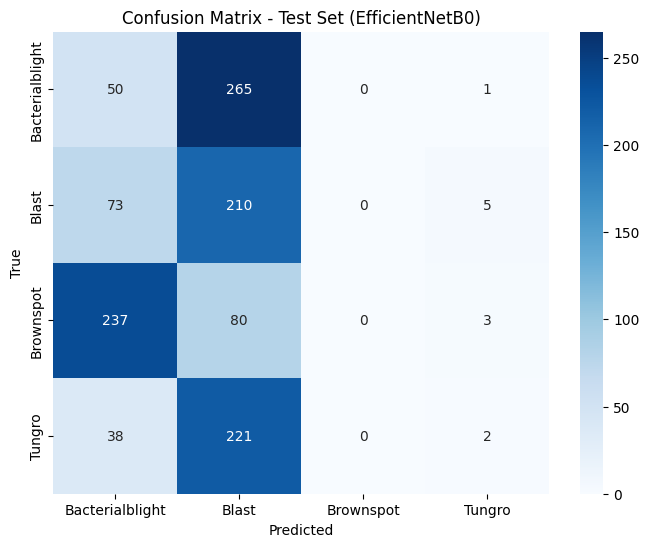

In [15]:
# Step 8: Classification report and confusion matrix
test_generator.reset()
test_preds = efficientnet_model.predict(test_generator)
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_generator.classes

print("Test Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=class_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y_true, test_y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Test Set (EfficientNetB0)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('./confusion_matrix_test_efficientnet.png')
plt.show()

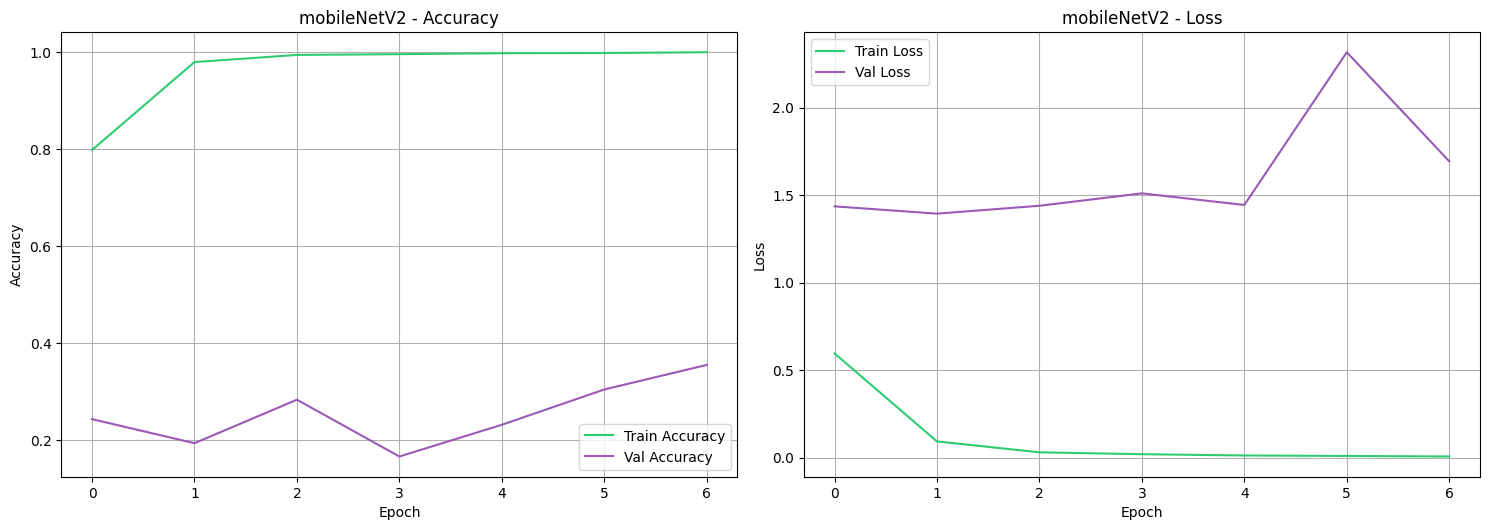

In [16]:
# Step 9: Plot training history 
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history.get('precision', [])
    val_precision = history.history.get('val_precision', [])
    recall = history.history.get('recall', [])
    val_recall = history.history.get('val_recall', [])
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 10))
    
    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', color='#2ecc71')  # Green
    plt.plot(epochs_range, val_acc, label='Val Accuracy', color='#9b59b6')  # Purple
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color='#2ecc71')
    plt.plot(epochs_range, val_loss, label='Val Loss', color='#9b59b6')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Precision plot
    if precision and val_precision:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, precision, label='Train Precision', color='#2ecc71')
        plt.plot(epochs_range, val_precision, label='Val Precision', color='#9b59b6')
        plt.title(f'{title} - Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)
    
    # Recall plot
    if recall and val_recall:
        plt.subplot(2, 2, 4)
        plt.plot(epochs_range, recall, label='Train Recall', color='#2ecc71')
        plt.plot(epochs_range, val_recall, label='Val Recall', color='#9b59b6')
        plt.title(f'{title} - Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('./training_history_efficientnet.png', dpi=300)
    plt.show()

plot_history(efficientnet_history, "mobileNetV2")